# Raport

# Krótkie odpowiedzi na pytania

* Ile znajduje się w zbiorze cech kategorycznych, a ile numerycznych

Mamy 5 wartości numerycznych, pozostałe są nominalne

* Czy zmienna wyjściowa jest kategoryczna, czy numeryczna

Jest numeryczną

* Czy i ile w zbiorze jest brakujących wartości? Dla jakich zmiennych? Co z tego wynika?

Dla wartości niezbędnych do analizy wydźwięku procent brakujących wartości wynosi mniej niż 1 procent

* Czy któreś z cech są skorelowane? Co z tego może wynikać?

Ogólnie nie mamy silnych korelacji

* Czy któraś z cech koreluje ze zmienną wyjściową? Jeśli tak - która? Czy któraś nie koreluje?
'overall' ma relatywnie wysoką korelacje dla czasu i kategorji, ale nie ma dostatecznie silnych korelacji

* Czy zbiór danych wydaje się być wystarczająco informacyjny by rozwiązać zadanie analizy sentymentu?

Tak

* Czy któreś ze słów wydają się dominować w zbiorze?
W tekście dominują słowa "pomocnicze" jak "the", "in", "for" etc. Po usunęciu "common language" dominują słowy opisujący towar (co to jest, czy pracuje)

* Czy najpopularniejsze słowa różnią się znacząco pomiędzy klasami? Czy potrafisz wyróżnić słowa mogące wpływać w znaczym stopniu na sentyment?

Możemy rozróżnić słowy pomiędzy klasami z uwagą, że różnice są mniej widoczne porównując 1 z 2 i 3 z 4

* Jaka jest charakterystyka tekstu 

Najwięcej tekstów o krótkiej długości (do ok. 5 tyś symboli dla 'reviewText' i 60 symboli do 'summary')

# Ogólne wnioski

Dane mają dużo atrybutów, ale do budowania modelu przydatna jest tylko część. Niezbędnymi są atrybuty tekstowe 'summary' i 'reviewText' i atrybut klasy 'overall'.

Do budowaniu modelu mogą też pszydać 'category' i 'unixReviewTime' (lub inna wartość czasu), które nie mają brakujące wartości, jednak to zależy od celu modelu, czy chcemy ogólnie analizować tekst na sentyment lub chcemy model analizy sentymentów dla review na Amazon dla wybranych kategorii i/lub czasu (bo dla różnych kategorii i czasu mogą być inne kryterium dla dobrego lub złego produktu).

Nie mamy silnych korelacji pomiędzy atrybutami numerycznymi. Ale nie jest to problemem bo bardziej nam potrzebne wartości nominalne i nie stoi nam problem redukcji wymiarowości.

Jedną z największych problemów który ma ten dataset to nierównomierny rozkład wartości klas. Klas o wartości '1' (najlepszy sentyment) jest więcej niż wszystkich pozostałych. Może to spowodować problemy z uczeniem i ewaluacją modelu, bo model może się nauczyć wykrywać tylko klasę '1'.

Następnym problemem jest jakie słowa używać, bo najwięcej występują słowy zawierające niewiele informacji jak "the", "for", "i" itd. Możemy przy pomocy bibliotek usunąć takie słowy, ale wtedy tracimy takie słowy jak "not" i "but", które zawirają potzebną nam informacje. Ale nawet po usunięciu "common language" mamy zbędne słowy jako typ produktu lub jakieś przedmioty. Dlatego pytaniem jest jak wybrać potrzebne lub jak usunąć niepotrzebne słowy dla budowania modelu, czy wybrać pewne słowy które będą używane do analizy lub dopasować listę zbędnych słów aby nie usuwały się nam słowy niezbędne.



# Początek EDA

Analiza danych po ekstrakcji cech

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

pd.options.display.max_columns = 30

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
split_path = './data/features/'

train_file_name = 'Amazon_train.json'
test_file_name = 'Amazon_test.json'

df_train = pd.read_json(os.path.join(split_path, train_file_name))
df_test = pd.read_json(os.path.join(split_path, test_file_name))

df = pd.concat([df_train, df_test], axis = 0)

# Ogólna analiza danych

In [3]:
df

,overall,verified,reviewTime,reviewerID,asin,style_list,reviewerName,reviewText,summary,unixReviewTime,vote,image,category,package quantity,design,format,scent name,flavor,style,package type,style name,color,size,size name,platform,summary_length,reviewText_length,year_period
8028,5,True,"05 16, 2018",ASECGGNQIT2RN,B014IBJKNO,"{'Size:': ' 10 M US', 'Color:': ' Black/White/...",Debra DeGrand,Love these shoes!,Very confortable!,1526428800,None,None,AMAZON_FASHION_5,NaN,None,None,None,None,None,None,None,Black/White/Anthracite/Stealth,10 M US,None,None,17,17,spring
17270,1,False,"03 9, 2014",A5MXNEKQSVHEG,B008H3SW4I,{'Format:': ' Software'},d arivas,This operating system has caused us nothing bu...,A total waste of time and money,1394323200,8,None,Software_5,NaN,None,Software,None,None,None,None,None,None,None,None,None,31,616,spring
4558,5,True,"03 3, 2015",A39KHX3058560R,B001OHV1H4,{'Size:': ' 26'},D. Lewis,I have always liked Prell conditioner and so d...,"Prell conditioner, family favorite.",1425340800,None,None,All_Beauty_5,NaN,None,None,None,None,None,None,None,None,26,None,None,35,170,spring
9220,5,True,"02 25, 2017",A8WEXFRWX1ZHH,B0006GVNOA,None,Goldengate,I bought this last October and finally got aro...,A great device that has my dryer working well ...,1487980800,311,None,Appliances_5,NaN,None,None,None,None,None,None,None,None,None,None,None,78,1662,winter
21501,5,False,"05 30, 2015",A1HYH206E18XVC,B00UV3VCLC,{'Platform:': ' PC Disc'},Bass Cadet,As a user of Cyberlink's PowerDirector softwar...,Nice multimedia player,1432944000,None,None,Software_5,NaN,None,None,None,None,None,None,None,None,None,None,PC Disc,22,1109,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14966,3,False,"10 22, 2009",A13EQE9EY2ET93,B002DHLV8S,{'Format:': ' Software'},Daviangel,Having been a loyal Windows customer and payin...,Overpriced!,1256169600,122,None,Software_5,NaN,None,Software,None,None,None,None,None,None,None,None,None,12,5539,autumn
21033,1,True,"08 28, 2017",AN5FTWFGH183S,B00OVT6VKY,None,Terry D. Russell,Not used. May be ok I just didn't use it.,One Star,1503878400,None,None,Software_5,NaN,None,None,None,None,None,None,None,None,None,None,None,8,41,summer
4840,5,False,"10 4, 2017",A3FMPT5IH0CJ50,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Sandalwood'}",Lindsey Jane,This soap is great. It foams up and is so nice...,Amazing Soap,1507075200,None,None,All_Beauty_5,NaN,None,None,None,None,None,None,None,Sandalwood,250 Gram,None,None,12,169,autumn
6836,5,True,"06 28, 2016",A3LJ4LLR2UX4CB,B009MA34NY,"{'Size:': ' 8 B(M) US', 'Color:': ' Black/Whit...",C.L.,I am so happy with this purchase. I feel like ...,I am so happy with this purchase,1467072000,7.0,None,AMAZON_FASHION_5,NaN,None,None,None,None,None,None,None,Black/White/Anthracite/Stealth,8 B(M) US,None,None,32,288,summer


In [4]:
(df.isna().sum(axis=0).to_frame().transpose() / df.shape[0] * 100)


,overall,verified,reviewTime,reviewerID,asin,style_list,reviewerName,reviewText,summary,unixReviewTime,vote,image,category,package quantity,design,format,scent name,flavor,style,package type,style name,color,size,size name,platform,summary_length,reviewText_length,year_period
0,0.0,0.0,0.0,0.0,0.0,36.540995,0.038254,0.09351,0.046755,0.0,70.990777,95.311769,0.0,99.99575,99.910741,89.178391,99.957496,99.948995,99.655715,99.812981,99.774727,82.335189,68.185489,99.940494,81.429847,0.0,0.0,0.0


* Czy i ile w zbiorze jest brakujących wartości? Dla jakich zmiennych? Co z tego wynika?

W polach 'summary' i 'reviewText', zawierające tekst i które mają największe znaczenie w analizie wydźwięku, brakujących wartości jest mniej 1%, co jest dobre, bo prawie całe dane są przygodne do analizy.

Nie mamy brakujących wartości w etykietach klas, co też jest dobre.

Dużo brakujących wartości mamy w 'style_list' (oryginalnie Style) i odpowiednio w atrybutach, które powstały w procesie atomizacji: 'package quantity', 'design', 'format', 'scent name', 'flavor', 'style', 'package type', 'style name', 'color, size', 'size name', 'platform'. Nie są do użycia w trenowaniu modelu.

Mamy dużo brakujących wartości w vote, to jest liczba odznaczeń od innych użytkowników, że ten review jest użyteczny. Nie obchodzi nas w analizie wydźwięku 

Image ma dużo brakujących wartości, ale ona zawiera link do obrazu, nie obchodzi nas w analizie wydźwięku

'reviewerID' to ID użytkownika, nie ma brakujących wartości

'asin' to ID produktu na Amazon, nie ma brakujących wartości

'category' jest to kategoria produktu, nie ma brakujących wartości

'reviewTime' i 'unixReviewTime' to czas (data w godzinie 00:00) w którym review został wysłany, nie ma brakujących wartości

'summary_length', 'year_period' i 'time_period' to atrybuty oparte na atrybutach 'summary' i 'unixReviewTime' (i odpowiednio reviewTime)

'year_period' i 'time_period' to wartości kategoryczne

* Czy zbiór danych wydaje się być wystarczająco informacyjny by rozwiązać zadanie analizy sentymentu?

W najważniejszych atrybutach dla analizy sentymentu, 'overall', 'summary' i 'reviewText', mamy bardzo mało brakujących wartości, dlatego prawie cały dataset jest przydatny do analizy. 


# Analiza danych numerycznych

In [5]:
df.describe()

,overall,unixReviewTime,package quantity,summary_length,reviewText_length
count,23527.000000,2.352700e+04,1.0,23527.000000,23527.000000
mean,4.209334,1.400087e+09,1.0,29.597994,746.769074
std,1.220591,9.952275e+07,NaN,22.187833,1228.868359
min,1.000000,9.619776e+08,1.0,0.000000,0.000000
25%,4.000000,1.353283e+09,1.0,10.000000,88.000000
50%,5.000000,1.425600e+09,1.0,22.000000,296.000000
75%,5.000000,1.477958e+09,1.0,42.000000,993.500000
max,5.000000,1.535242e+09,1.0,128.000000,31644.000000


* Ile znajduje się w zbiorze cech kategorycznych, a ile numerycznych

W zbiorze mamy 5 wartości numerycznych

* Czy zmienna wyjściowa jest kategoryczna, czy numeryczna? 

Etykieta klasy jest wartością numeryczną, co znaczy że output modelu jest też numeryczny

In [6]:
df_corr = df[['overall', 'unixReviewTime', 'summary_length', 'reviewText_length', 'category', 'year_period']]

# 'package quantity' usunięte bo maje tylko jedną wartość

df_corr['category'] = df_corr['category'].apply(lambda x: 1 if x == 'Software_5' 
                                                else 2 if x =='All_Beauty_5' 
                                                else 3 if x =='AMAZON_FASHION_5'
                                                else 4)

df_corr['year_period'] = df_corr['year_period'].apply(lambda x: 1 if x =='winter' 
                                                else 2 if x =='spring' 
                                                else 3 if x =='autumn'
                                                else 4)

df_corr.corr()

/tmp/ipykernel_17/2647948001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['category'] = df_corr['category'].apply(lambda x: 1 if x == 'Software_5'
/tmp/ipykernel_17/2647948001.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['year_period'] = df_corr['year_period'].apply(lambda x: 1 if x =='winter'


,overall,unixReviewTime,summary_length,reviewText_length,category,year_period
overall,1.000000,0.180766,-0.106525,-0.138377,0.213323,0.028582
unixReviewTime,0.180766,1.000000,-0.048859,-0.238753,0.505372,-0.051036
summary_length,-0.106525,-0.048859,1.000000,0.385814,0.015382,-0.077404
reviewText_length,-0.138377,-0.238753,0.385814,1.000000,-0.060247,-0.048446
category,0.213323,0.505372,0.015382,-0.060247,1.000000,-0.109352
year_period,0.028582,-0.051036,-0.077404,-0.048446,-0.109352,1.000000


* Czy któreś z cech są skorelowane? Co z tego może wynikać?

Mamy jakoś korelacje pomiędzy 'unixReviewTime' i 'category', to może wskazać na sezonowe trendy

Mamy małą korelacje pomiędzy 'summary_length' i 'reviewText_length', długie teksty mają długie uogólnienia

Mamy mała korelacje pomiędzy 'category' i 'overall', możemy zrobić hipotezę że jakieś kategorie produktów ogólnie otrzymują 

Ogólnie nie mamy silnych korelacji

* Czy któraś z cech koreluje ze zmienną wyjściową? Jeśli tak - która? Czy któraś nie koreluje?

'overall' ma relatywnie wysoką korelacje dla czasu i kategorii, ale nie ma dostatecznie silnych korelacji

# Analiza danych tekstowych

In [7]:
all_words_inReview = [y.lower() for x in df['reviewText'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if len(y) > 0]
all_words_inSummary = [y.lower() for x in df['summary'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if len(y) > 0]

words_counter_Rev = collections.Counter(all_words_inReview)
words_counter_Sum = collections.Counter(all_words_inSummary)

Top N najwięcej występujących słów

In [8]:
N = 15

print('\nSłowy w reviewText')
for x in sorted(list(words_counter_Rev.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nSłowy w summary')
for x in sorted(list(words_counter_Sum.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nOverall')
for x in sorted(list((words_counter_Rev + words_counter_Sum).items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)




Słowy w reviewText
	 ('the', 148883)
	 ('to', 94847)
	 ('and', 89453)
	 ('i', 84757)
	 ('a', 75904)
	 ('it', 58199)
	 ('of', 53404)
	 ('is', 44267)
	 ('you', 39354)
	 ('for', 37112)
	 ('this', 36611)
	 ('that', 34553)
	 ('in', 33882)
	 ('with', 29503)
	 ('my', 26908)

Słowy w summary
	 ('stars', 4207)
	 ('five', 3311)
	 ('a', 2956)
	 ('the', 2596)
	 ('great', 2477)
	 ('for', 2375)
	 ('to', 2340)
	 ('and', 2300)
	 ('it', 2055)
	 ('good', 1690)
	 ('product', 1505)
	 ('i', 1470)
	 ('this', 1468)
	 ('my', 1248)
	 ('of', 1182)

Overall
	 ('the', 151479)
	 ('to', 97187)
	 ('and', 91753)
	 ('i', 86227)
	 ('a', 78860)
	 ('it', 60254)
	 ('of', 54586)
	 ('is', 45373)
	 ('you', 39940)
	 ('for', 39487)
	 ('this', 38079)
	 ('that', 35279)
	 ('in', 34366)
	 ('with', 30437)
	 ('my', 28156)


* Czy któreś ze słów wydają się dominować w zbiorze?

W reviewText najwięcej występują słowy 'wspomagające' i nie niosą dużo informacji. Taka sama tendencja jest i w Summary.

Ciekawą informacje mamy w 'summary', najwięcej mamy słów pozytywne "five" "stars" "good". Aby zrobić z tego wniosek musimy sprawdzić występowanie klas.

In [9]:
df['overall'].value_counts()

5    14391
4     4041
3     2465
1     1741
2      889
Name: overall, dtype: int64

To potwierdza nasze obserwacje w 'summary', najwięcej mamy pozytywnych ocen, ocen w 5 gwiazd jest więcej niż wszystkich pozostałych ocen.

$$---$$

Teraz użyjemy NLTK aby usunąć 'common language'

In [10]:
all_words_inReview = [y.lower() for x in df['reviewText'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if (len(y) > 0)]
all_words_inSummary = [y.lower() for x in df['summary'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if (len(y) > 0)]

words_counter_Rev = collections.Counter((x,y) for x,y in collections.Counter(all_words_inReview).items() if not x in stopwords.words())
words_counter_Sum = collections.Counter((x,y) for x,y in collections.Counter(all_words_inSummary).items() if not x in stopwords.words())


In [11]:
N = 15

print('\nSłowy w reviewText')
for x in sorted(list(words_counter_Rev.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nSłowy w summary')
for x in sorted(list(words_counter_Sum.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nOverall')
for x in sorted(list((words_counter_Rev + words_counter_Sum).items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)




Słowy w reviewText
	 (('love', 3482), 1)
	 (('shoes', 1338), 1)
	 (('operating', 939), 1)
	 (('system', 3131), 1)
	 (('caused', 208), 1)
	 (('trouble', 576), 1)
	 (('300', 38), 1)
	 (('clients', 95), 1)
	 (('york', 16), 1)
	 (('ending', 270), 1)
	 (('array', 161), 1)
	 (('incompatibilities', 14), 1)
	 (('failures', 11), 1)
	 (('simple', 1857), 1)
	 (('things', 2603), 1)

Słowy w summary
	 (('confortable', 16), 1)
	 (('total', 23), 1)
	 (('waste', 39), 1)
	 (('time', 242), 1)
	 (('money', 351), 1)
	 (('prell', 5), 1)
	 (('conditioner', 44), 1)
	 (('family', 47), 1)
	 (('favorite', 176), 1)
	 (('great', 2477), 1)
	 (('device', 227), 1)
	 (('dryer', 415), 1)
	 (('working', 255), 1)
	 (('simple', 307), 1)
	 (('instructions', 212), 1)

Overall
	 (('reordered', 8), 2)
	 (('firmed', 5), 2)
	 (('orange/coral', 8), 2)
	 (('unethical', 4), 2)
	 (('r10', 2), 2)
	 (('paraben-free', 5), 2)
	 (('sciatica', 8), 2)
	 (('"special"', 2), 2)
	 (('affordably', 1), 2)
	 (('waaaaay', 2), 2)
	 (('dressed', 

Widać że w 'reviewText' najwięcej słów opisujących produkt i w wybranych słowach tylko "great" jest słowem opisującym emocje.

To samo mniej więcej widać w 'summary', ale mamy więcej słów oceniających

* Jaka jest charakterystyka tekstu (np. długość, czystość)?

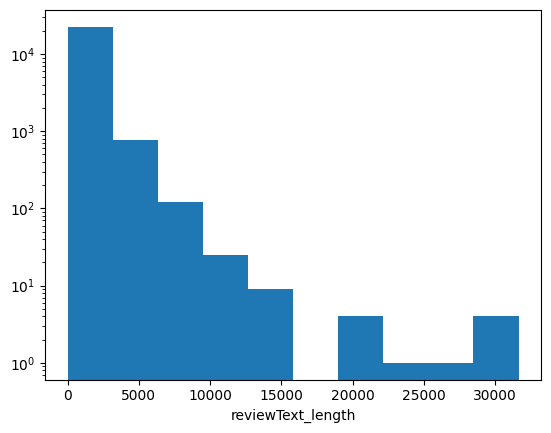

In [12]:
plt.yscale("log")
plt.xlabel('reviewText_length')
plt.hist(df['reviewText_length'])
plt.show()

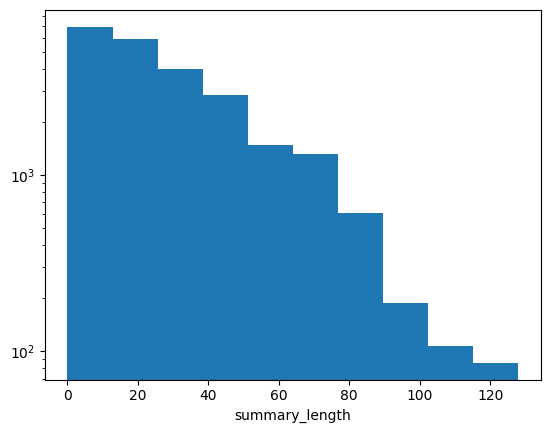

In [13]:
plt.yscale("log")
plt.xlabel('summary_length')
plt.hist(df['summary_length'])

plt.show()

# Analiza tekstu class-wise

In [14]:
classNum = 5
N = 15

all_words_inReview = [y.lower() for x in df[df['overall'] == classNum]['reviewText'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if len(y) > 0]
all_words_inSummary = [y.lower() for x in df[df['overall'] == classNum]['summary'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if len(y) > 0]

words_counter_Rev = collections.Counter(all_words_inReview)
words_counter_Sum = collections.Counter(all_words_inSummary)

print('\nSłowy w reviewText')
for x in sorted(list(words_counter_Rev.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nSłowy w summary')
for x in sorted(list(words_counter_Sum.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nOverall')
for x in sorted(list((words_counter_Rev + words_counter_Sum).items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)


Słowy w reviewText
	 ('the', 72578)
	 ('and', 45934)
	 ('i', 41371)
	 ('to', 40675)
	 ('a', 33542)
	 ('it', 25862)
	 ('of', 25096)
	 ('is', 19698)
	 ('this', 18258)
	 ('for', 16921)
	 ('you', 15516)
	 ('in', 13766)
	 ('my', 13755)
	 ('that', 13656)
	 ('with', 13585)

Słowy w summary
	 ('stars', 3528)
	 ('five', 3304)
	 ('great', 1853)
	 ('a', 1817)
	 ('and', 1448)
	 ('the', 1377)
	 ('for', 1300)
	 ('product', 1160)
	 ('this', 1052)
	 ('to', 1046)
	 ('my', 945)
	 ('it', 933)
	 ('i', 838)
	 ('love', 777)
	 ('excellent', 777)

Overall
	 ('the', 73955)
	 ('and', 47382)
	 ('i', 42209)
	 ('to', 41721)
	 ('a', 35359)
	 ('it', 26795)
	 ('of', 25765)
	 ('is', 20258)
	 ('this', 19310)
	 ('for', 18221)
	 ('you', 15770)
	 ('my', 14700)
	 ('that', 14270)
	 ('in', 14010)
	 ('with', 13911)


* Czy najpopularniejsze słowa różnią się znacząco pomiędzy klasami? Czy potrafisz wyróżnić słowa mogące wpływać w znacznym stopniu na sentyment?

Po analizie co klasy możemy wyróżnić następne słowy (dla wszystkich kategorii słów):

1: not, buy, don't

2: not

3: not, but, good, needs

4: good, great, works, but, four, just

5: five, great, excellent, love,

$$---$$

Analiza z NLTK

In [15]:
classNum = 1
N = 15

all_words_inReview = [y.lower() for x in df[df['overall'] == classNum]['reviewText'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if len(y) > 0]
all_words_inSummary = [y.lower() for x in df[df['overall'] == classNum]['summary'].to_list() if x != None for y in re.split('\s|!|,|\.|\?', x)  if len(y) > 0]

words_counter_Rev = collections.Counter(dict((x,y) for x,y in collections.Counter(all_words_inReview).items() if not x in stopwords.words()))
words_counter_Sum = collections.Counter(dict((x,y) for x,y in collections.Counter(all_words_inSummary).items() if not x in stopwords.words()))

print('\nSłowy w reviewText')
for x in sorted(list(words_counter_Rev.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nSłowy w summary')
for x in sorted(list(words_counter_Sum.items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)

print('\nOverall')
for x in sorted(list((words_counter_Rev + words_counter_Sum).items()), key = lambda x: x[1], reverse = True)[:N]:
    print('\t',x)


Słowy w reviewText
	 ('software', 1335)
	 ('windows', 1308)
	 ('product', 1035)
	 ('version', 810)
	 ('program', 808)
	 ('quicken', 765)
	 ('time', 755)
	 ('computer', 706)
	 ('work', 638)
	 ('-', 603)
	 ('support', 509)
	 ('microsoft', 494)
	 ('system', 489)
	 ('8', 484)
	 ('norton', 464)

Słowy w summary
	 ('star', 146)
	 ('buy', 79)
	 ('product', 75)
	 ('-', 74)
	 ('work', 68)
	 ('software', 68)
	 ('windows', 60)
	 ('money', 58)
	 ('worst', 43)
	 ('time', 39)
	 ('poor', 39)
	 ('version', 38)
	 ('beware', 36)
	 ('buggy', 36)
	 ('waste', 34)

Overall
	 ('software', 1403)
	 ('windows', 1368)
	 ('product', 1110)
	 ('version', 848)
	 ('program', 832)
	 ('time', 794)
	 ('quicken', 789)
	 ('computer', 732)
	 ('work', 706)
	 ('-', 677)
	 ('support', 543)
	 ('microsoft', 519)
	 ('8', 501)
	 ('norton', 496)
	 ('system', 494)


Po analizie co klasy możemy wyróżnić następne słowy (dla wszystkich kategorii słów):

1: failures, trouble, incompatibilities, waste, money, worthless, painfully

2: buggy, free, problem, poor, slow

3: easy, great, works, decent

4: easy, great, excellent, nice, works

5: great, love, easy, clean, easy, excellent, woked, works